In [1]:
# Setup and imports
import sys
import os

# Add the project root to Python path
if 'notebooks' in os.getcwd():
    project_root = os.path.dirname(os.getcwd())
else:
    project_root = os.getcwd()

if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from typing import Dict, List, Any, Tuple

# Handle plotly imports with auto-installation
PLOTLY_AVAILABLE = False
try:
    import plotly.graph_objects as go
    import plotly.express as px
    PLOTLY_AVAILABLE = True
    print("✅ Plotly loaded successfully")
except ImportError:
    try:
        print("📦 Installing plotly...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly"])
        import plotly.graph_objects as go
        import plotly.express as px
        PLOTLY_AVAILABLE = True
        print("✅ Plotly installed and loaded")
    except Exception as e:
        print(f"⚠️ Could not install plotly: {e}")
        print("   Visualizations will use matplotlib fallback")

# Handle ipywidgets imports with auto-installation  
WIDGETS_AVAILABLE = False
try:
    import ipywidgets as widgets
    WIDGETS_AVAILABLE = True
    print("✅ IPywidgets loaded successfully")
except ImportError:
    try:
        print("📦 Installing ipywidgets...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "ipywidgets"])
        import ipywidgets as widgets
        WIDGETS_AVAILABLE = True
        print("✅ IPywidgets installed and loaded")
    except Exception as e:
        print(f"⚠️ Could not install ipywidgets: {e}")
        print("   Interactive features will be limited")

# Import our component registry
from models.component_registry import ComponentRegistry, ComponentCategory

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100

print("✅ Setup completed!")
print(f"📂 Project root: {project_root}")
print(f"🔧 Plotly available: {PLOTLY_AVAILABLE}")
print(f"🎛️ Widgets available: {WIDGETS_AVAILABLE}")

✅ Plotly loaded successfully
✅ IPywidgets loaded successfully
✅ Setup completed!
📂 Project root: /Users/jmarwell/Desktop/Projects/drip/acoustic-sysml-v2
🔧 Plotly available: True
🎛️ Widgets available: True


In [2]:
# Setup and imports
import sys
import os

# Add the project root to Python path
if 'notebooks' in os.getcwd():
    project_root = os.path.dirname(os.getcwd())
else:
    project_root = os.getcwd()

if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from typing import Dict, List, Any, Tuple

# Handle plotly imports with auto-installation
PLOTLY_AVAILABLE = False
try:
    import plotly.graph_objects as go
    import plotly.express as px
    PLOTLY_AVAILABLE = True
    print("✅ Plotly loaded successfully")
except ImportError:
    try:
        print("📦 Installing plotly...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly"])
        import plotly.graph_objects as go
        import plotly.express as px
        PLOTLY_AVAILABLE = True
        print("✅ Plotly installed and loaded")
    except Exception as e:
        print(f"⚠️ Could not install plotly: {e}")
        print("   Visualizations will use matplotlib fallback")

# Handle ipywidgets imports with auto-installation  
WIDGETS_AVAILABLE = False
try:
    import ipywidgets as widgets
    WIDGETS_AVAILABLE = True
    print("✅ IPywidgets loaded successfully")
except ImportError:
    try:
        print("📦 Installing ipywidgets...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "ipywidgets"])
        import ipywidgets as widgets
        WIDGETS_AVAILABLE = True
        print("✅ IPywidgets installed and loaded")
    except Exception as e:
        print(f"⚠️ Could not install ipywidgets: {e}")
        print("   Interactive features will be limited")

# Import our component registry
from models.component_registry import ComponentRegistry, ComponentCategory

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100

print("✅ Setup completed!")
print(f"📂 Project root: {project_root}")
print(f"🔧 Plotly available: {PLOTLY_AVAILABLE}")
print(f"🎛️ Widgets available: {WIDGETS_AVAILABLE}")

✅ Plotly loaded successfully
✅ IPywidgets loaded successfully
✅ Setup completed!
📂 Project root: /Users/jmarwell/Desktop/Projects/drip/acoustic-sysml-v2
🔧 Plotly available: True
🎛️ Widgets available: True


In [3]:
# Initialize registry and verify TechnicalSpecs
registry = ComponentRegistry()

# Verify TechnicalSpecs are present
sample_comp = registry.components[0]
if hasattr(sample_comp, 'tech_specs'):
    print(f"✅ TechnicalSpecs loaded for all {len(registry.components)} components")
    print(f"✅ Categories: {[cat.value for cat in ComponentCategory]}")
    
    # NEW: Use updated power budget calculation with proper supply tracking
    power_budget = registry.calculate_power_budget()
    total_consumption = power_budget['TOTAL']['active_power']
    total_supply = power_budget['TOTAL']['power_supply'] 
    net_power = power_budget['TOTAL']['net_power']
    
    print(f"✅ Total Power Consumption: {total_consumption:,.0f}W")
    print(f"✅ Total Power Supply: {total_supply:,.0f}W")
    print(f"✅ Net Power Required: {net_power:,.0f}W")
    
    # Check against power budget
    budget = 12000  # W
    if net_power <= budget:
        margin = budget - net_power
        margin_pct = (margin/budget)*100
        print(f"✅ Power Budget: WITHIN LIMIT")
        print(f"✅ Available Margin: {margin:,.0f}W ({margin_pct:.1f}%)")
    else:
        print(f"❌ Power Budget: EXCEEDS LIMIT by {net_power-budget:,.0f}W")
else:
    print("⚠️ TechnicalSpecs not found - please update component_registry.py")

✅ TechnicalSpecs loaded for all 51 components
✅ Categories: ['Frame Subsystem', 'Heated Bed Subsystem', 'Acoustic Cylinder Subsystem', 'Crucible Subsystem', 'Power/Control Subsystem']
✅ Total Power Consumption: 14,596W
✅ Total Power Supply: 10,000W
✅ Net Power Required: 4,596W
✅ Power Budget: WITHIN LIMIT
✅ Available Margin: 7,404W (61.7%)


🔧 COMPREHENSIVE DIMENSIONAL ANALYSIS

📐 Components by Volume (Top 15):


,Component,Category,Dimensions,Qty,Unit Volume (L),Total Volume (L)
2,Frame,Frame Subsystem,500×500×800mm,1,200.000,200.000
37,Control Enclosure,Power/Control Subsystem,500×400×200mm,1,40.000,40.000
19,Induction Heater,Crucible Subsystem,400×300×200mm,1,24.000,24.000
28,Material Delivery System,Crucible Subsystem,200×200×150mm,1,6.000,6.000
10,Heated Bed Assembly,Heated Bed Subsystem,300×300×50mm,1,4.500,4.500
17,Cooling Layer,Acoustic Cylinder Subsystem,300×300×50mm,1,4.500,4.500
32,10kW PSU,Power/Control Subsystem,280×140×90mm,1,3.528,3.528
26,Material Feed System,Crucible Subsystem,200×150×100mm,1,3.000,3.000
12,Thermal Isolation Tube,Heated Bed Subsystem,Ø350/300×100mm,1,2.553,2.553
0,Kapton Tubes,Frame Subsystem,Ø101.6×150mm,2,1.216,2.432



📦 Total Component Volume: 307.8 Liters

📏 System Envelope Requirements:
----------------------------------------
  Frame Envelope: 500×500×800mm
  Frame Volume: 0.200 m³

🔲 Recommended Clearances:
----------------------------------------
  Service Access: 300mm
  Thermal Clearance: 150mm
  Cable Management: 100mm
  Ventilation: 200mm

  Minimum Room Footprint: 1.1×1.1m
  Minimum Ceiling Height: 1.1m


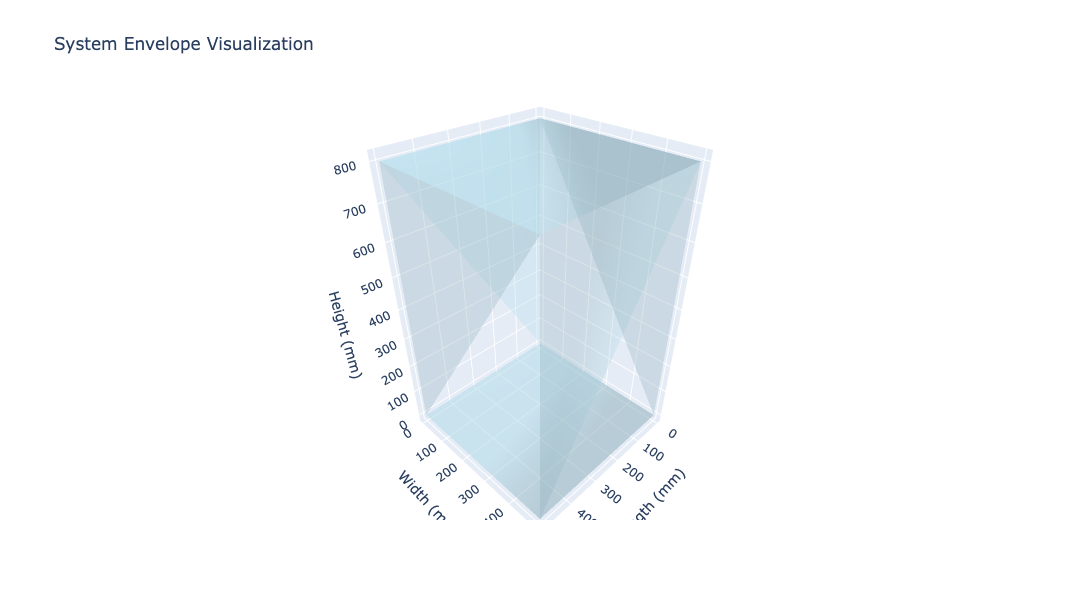

In [4]:
def comprehensive_dimensional_analysis():
    """Complete dimensional analysis with volume calculations and spatial planning"""
    
    # Ensure registry is available
    if 'registry' not in globals():
        global registry
        registry = ComponentRegistry()
    
    print("🔧 COMPREHENSIVE DIMENSIONAL ANALYSIS")
    print("=" * 80)
    
    # 1. Component Dimensions Summary
    dimension_data = []
    total_volume = 0
    
    for comp in registry.components:
        if comp.tech_specs.dimensions:
            dims = comp.tech_specs.dimensions
            
            # Calculate volume based on available dimensions
            volume = 0
            dim_str = ""
            
            if 'L' in dims and 'W' in dims and 'H' in dims:
                volume = dims['L'] * dims['W'] * dims['H'] / 1e6  # Convert to liters
                dim_str = f"{dims['L']}×{dims['W']}×{dims['H']}mm"
            elif 'D' in dims and 'H' in dims:
                volume = 3.14159 * (dims['D']/2)**2 * dims['H'] / 1e6  # Cylinder
                dim_str = f"Ø{dims['D']}×{dims['H']}mm"
            elif 'D' in dims and 'L' in dims:
                volume = 3.14159 * (dims['D']/2)**2 * dims['L'] / 1e6
                dim_str = f"Ø{dims['D']}×{dims['L']}mm"
            elif 'D_outer' in dims and 'D_inner' in dims and 'H' in dims:
                # Hollow cylinder
                outer_vol = 3.14159 * (dims['D_outer']/2)**2 * dims['H'] / 1e6
                inner_vol = 3.14159 * (dims['D_inner']/2)**2 * dims['H'] / 1e6
                volume = outer_vol - inner_vol
                dim_str = f"Ø{dims['D_outer']}/{dims['D_inner']}×{dims['H']}mm"
            
            if volume > 0:
                total_volume += volume * comp.quantity
                dimension_data.append({
                    'Component': comp.name,
                    'Category': comp.category.value,
                    'Dimensions': dim_str,
                    'Qty': comp.quantity,
                    'Unit Volume (L)': round(volume, 3),
                    'Total Volume (L)': round(volume * comp.quantity, 3)
                })
    
    # Display table of significant components
    if dimension_data:
        df = pd.DataFrame(dimension_data)
        df = df.sort_values('Total Volume (L)', ascending=False)
        print("\n📐 Components by Volume (Top 15):")
        display(df.head(15))
        print(f"\n📦 Total Component Volume: {total_volume:.1f} Liters")
    
    # 2. System Envelope Analysis
    print("\n📏 System Envelope Requirements:")
    print("-" * 40)
    
    # Find maximum dimensions
    max_envelope = {'L': 0, 'W': 0, 'H': 0}
    
    for comp in registry.components:
        if comp.category == ComponentCategory.FRAME and comp.tech_specs.dimensions:
            dims = comp.tech_specs.dimensions
            for key in ['L', 'W', 'H']:
                if key in dims:
                    max_envelope[key] = max(max_envelope[key], dims[key])
    
    print(f"  Frame Envelope: {max_envelope['L']}×{max_envelope['W']}×{max_envelope['H']}mm")
    
    if all(max_envelope.values()):
        frame_volume = max_envelope['L'] * max_envelope['W'] * max_envelope['H'] / 1e9
        print(f"  Frame Volume: {frame_volume:.3f} m³")
    
    # 3. Clearance Requirements
    print("\n🔲 Recommended Clearances:")
    print("-" * 40)
    clearances = {
        'Service Access': 300,  # mm
        'Thermal Clearance': 150,
        'Cable Management': 100,
        'Ventilation': 200
    }
    
    for purpose, clearance in clearances.items():
        print(f"  {purpose}: {clearance}mm")
    
    total_clearance = max(clearances.values())
    final_envelope = {
        'L': max_envelope['L'] + 2*total_clearance,
        'W': max_envelope['W'] + 2*total_clearance,
        'H': max_envelope['H'] + total_clearance  # Top clearance only
    }
    
    if all(final_envelope.values()):
        print(f"\n  Minimum Room Footprint: {final_envelope['L']/1000:.1f}×{final_envelope['W']/1000:.1f}m")
        print(f"  Minimum Ceiling Height: {final_envelope['H']/1000:.1f}m")
    
    # 4. Visualization (with proper error handling)
    if PLOTLY_AVAILABLE and all(max_envelope.values()):
        try:
            fig = go.Figure()
            
            # Add 3D box for system envelope
            x_coords = [0, max_envelope['L'], max_envelope['L'], 0, 0, max_envelope['L'], max_envelope['L'], 0]
            y_coords = [0, 0, max_envelope['W'], max_envelope['W'], 0, 0, max_envelope['W'], max_envelope['W']]  
            z_coords = [0, 0, 0, 0, max_envelope['H'], max_envelope['H'], max_envelope['H'], max_envelope['H']]
            
            fig.add_trace(go.Mesh3d(
                x=x_coords,
                y=y_coords, 
                z=z_coords,
                i=[0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3],
                j=[1, 2, 3, 0, 5, 6, 7, 4, 4, 5, 6, 7],
                k=[2, 3, 0, 1, 6, 7, 4, 5, 5, 6, 7, 4],
                opacity=0.3,
                color='lightblue',
                name='System Envelope'
            ))
            
            fig.update_layout(
                title="System Envelope Visualization",
                scene=dict(
                    xaxis_title="Length (mm)",
                    yaxis_title="Width (mm)",
                    zaxis_title="Height (mm)",
                    aspectmode='data'
                ),
                height=600
            )
            fig.show()
        except Exception as e:
            print(f"\n📊 3D visualization failed: {e}")
            print("   System envelope dimensions shown above")
    else:
        if not PLOTLY_AVAILABLE:
            print("\n📊 3D visualization requires plotly installation")
        else:
            print("\n📊 Insufficient dimension data for 3D visualization")
    
    return dimension_data

# Run the analysis
dim_data = comprehensive_dimensional_analysis()

## Advanced Dimensional Analysis and Space Planning

🔧 COMPREHENSIVE DIMENSIONAL ANALYSIS

📐 Components by Volume (Top 15):


,Component,Category,Dimensions,Qty,Unit Volume (L),Total Volume (L)
2,Frame,Frame Subsystem,500×500×800mm,1,200.000,200.000
37,Control Enclosure,Power/Control Subsystem,500×400×200mm,1,40.000,40.000
19,Induction Heater,Crucible Subsystem,400×300×200mm,1,24.000,24.000
28,Material Delivery System,Crucible Subsystem,200×200×150mm,1,6.000,6.000
10,Heated Bed Assembly,Heated Bed Subsystem,300×300×50mm,1,4.500,4.500
17,Cooling Layer,Acoustic Cylinder Subsystem,300×300×50mm,1,4.500,4.500
32,10kW PSU,Power/Control Subsystem,280×140×90mm,1,3.528,3.528
26,Material Feed System,Crucible Subsystem,200×150×100mm,1,3.000,3.000
12,Thermal Isolation Tube,Heated Bed Subsystem,Ø350/300×100mm,1,2.553,2.553
0,Kapton Tubes,Frame Subsystem,Ø101.6×150mm,2,1.216,2.432



📦 Total Component Volume: 307.8 Liters

📏 System Envelope Requirements:
----------------------------------------
  Frame Envelope: 500×500×800mm
  Frame Volume: 0.200 m³

🔲 Recommended Clearances:
----------------------------------------
  Service Access: 300mm
  Thermal Clearance: 150mm
  Cable Management: 100mm
  Ventilation: 200mm

  Minimum Room Footprint: 1.1×1.1m
  Minimum Ceiling Height: 1.1m


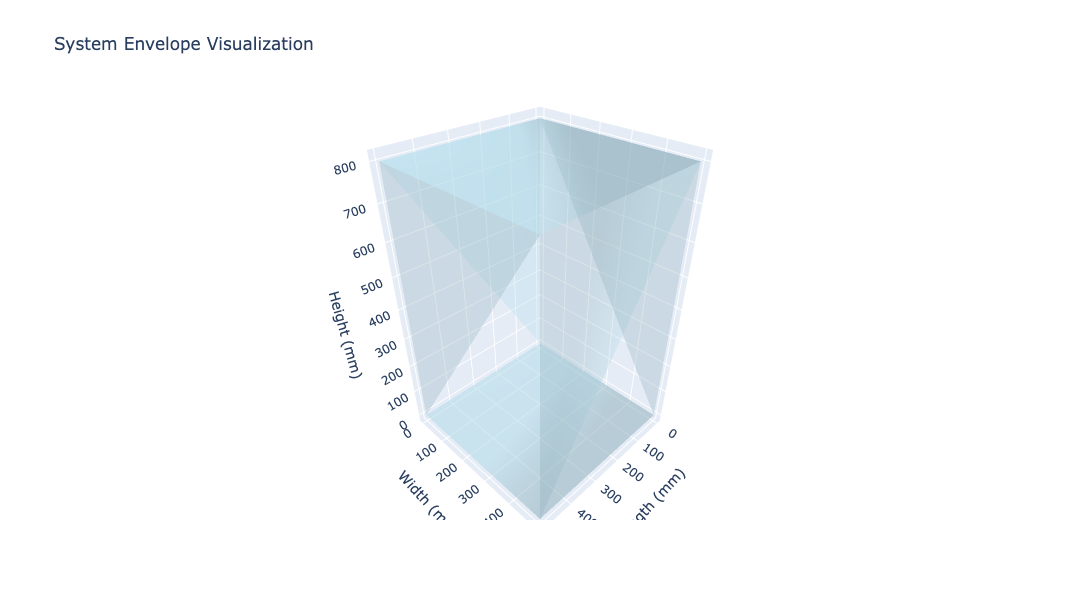

In [5]:
def comprehensive_dimensional_analysis():
    """Complete dimensional analysis with volume calculations and spatial planning"""
    
    print("🔧 COMPREHENSIVE DIMENSIONAL ANALYSIS")
    print("=" * 80)
    
    # 1. Component Dimensions Summary
    dimension_data = []
    total_volume = 0
    
    for comp in registry.components:
        if comp.tech_specs.dimensions:
            dims = comp.tech_specs.dimensions
            
            # Calculate volume based on available dimensions
            volume = 0
            dim_str = ""
            
            if 'L' in dims and 'W' in dims and 'H' in dims:
                volume = dims['L'] * dims['W'] * dims['H'] / 1e6  # Convert to liters
                dim_str = f"{dims['L']}×{dims['W']}×{dims['H']}mm"
            elif 'D' in dims and 'H' in dims:
                volume = 3.14159 * (dims['D']/2)**2 * dims['H'] / 1e6  # Cylinder
                dim_str = f"Ø{dims['D']}×{dims['H']}mm"
            elif 'D' in dims and 'L' in dims:
                volume = 3.14159 * (dims['D']/2)**2 * dims['L'] / 1e6
                dim_str = f"Ø{dims['D']}×{dims['L']}mm"
            elif 'D_outer' in dims and 'D_inner' in dims and 'H' in dims:
                # Hollow cylinder
                volume = 3.14159 * ((dims['D_outer']/2)**2 - (dims['D_inner']/2)**2) * dims['H'] / 1e6
                dim_str = f"Ø{dims['D_outer']}/{dims['D_inner']}×{dims['H']}mm"
            
            if volume > 0:
                total_volume += volume * comp.quantity
                dimension_data.append({
                    'Component': comp.name,
                    'Category': comp.category.value,
                    'Dimensions': dim_str,
                    'Qty': comp.quantity,
                    'Unit Volume (L)': round(volume, 3),
                    'Total Volume (L)': round(volume * comp.quantity, 3)
                })
    
    # Display table of significant components
    if dimension_data:
        df = pd.DataFrame(dimension_data)
        df = df.sort_values('Total Volume (L)', ascending=False)
        print("\n📐 Components by Volume (Top 15):")
        display(df.head(15))
        print(f"\n📦 Total Component Volume: {total_volume:.1f} Liters")
    
    # 2. System Envelope Analysis
    print("\n📏 System Envelope Requirements:")
    print("-" * 40)
    
    # Find maximum dimensions
    max_envelope = {'L': 0, 'W': 0, 'H': 0}
    frame_components = []
    
    for comp in registry.components:
        if comp.category == ComponentCategory.FRAME and comp.tech_specs.dimensions:
            dims = comp.tech_specs.dimensions
            frame_components.append(comp)
            for key in ['L', 'W', 'H']:
                if key in dims:
                    max_envelope[key] = max(max_envelope[key], dims[key])
    
    print(f"  Frame Envelope: {max_envelope['L']}×{max_envelope['W']}×{max_envelope['H']}mm")
    print(f"  Frame Volume: {max_envelope['L']*max_envelope['W']*max_envelope['H']/1e9:.3f} m³")
    
    # 3. Clearance Requirements
    print("\n🔲 Recommended Clearances:")
    print("-" * 40)
    clearances = {
        'Service Access': 300,  # mm
        'Thermal Clearance': 150,
        'Cable Management': 100,
        'Ventilation': 200
    }
    
    for purpose, clearance in clearances.items():
        print(f"  {purpose}: {clearance}mm")
    
    total_clearance = max(clearances.values())
    final_envelope = {
        'L': max_envelope['L'] + 2*total_clearance,
        'W': max_envelope['W'] + 2*total_clearance,
        'H': max_envelope['H'] + total_clearance  # Top clearance only
    }
    
    print(f"\n  Minimum Room Footprint: {final_envelope['L']/1000:.1f}×{final_envelope['W']/1000:.1f}m")
    print(f"  Minimum Ceiling Height: {final_envelope['H']/1000:.1f}m")
    
    # 4. Visualization
    fig = go.Figure()
    
    # Add 3D box for system envelope
    fig.add_trace(go.Mesh3d(
        x=[0, max_envelope['L'], max_envelope['L'], 0, 0, max_envelope['L'], max_envelope['L'], 0],
        y=[0, 0, max_envelope['W'], max_envelope['W'], 0, 0, max_envelope['W'], max_envelope['W']],
        z=[0, 0, 0, 0, max_envelope['H'], max_envelope['H'], max_envelope['H'], max_envelope['H']],
        i=[0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3],
        j=[1, 2, 3, 0, 5, 6, 7, 4, 4, 5, 6, 7],
        k=[2, 3, 0, 1, 6, 7, 4, 5, 5, 6, 7, 4],
        opacity=0.3,
        color='lightblue',
        name='System Envelope'
    ))
    
    fig.update_layout(
        title="System Envelope Visualization",
        scene=dict(
            xaxis_title="Length (mm)",
            yaxis_title="Width (mm)",
            zaxis_title="Height (mm)",
            aspectmode='data'
        ),
        height=600
    )
    fig.show()
    
    return dimension_data

# Run the analysis
dim_data = comprehensive_dimensional_analysis()

## Weight Distribution and Center of Mass Analysis

⚖️ WEIGHT DISTRIBUTION ANALYSIS

📊 Weight by Subsystem:
----------------------------------------
  Frame Subsystem                   45.99 kg ( 34.7%)
  Heated Bed Subsystem              20.02 kg ( 15.1%)
  Acoustic Cylinder Subsystem       18.39 kg ( 13.9%)
  Crucible Subsystem                28.96 kg ( 21.8%)
  Power/Control Subsystem           19.34 kg ( 14.6%)

  TOTAL                            132.70 kg

🏋️ Top 10 Heaviest Components:
----------------------------------------


,Component,Category,Unit Weight (kg),Qty,Total Weight (kg)
2,Frame,Frame Subsystem,25.0,1,25.0
23,Induction Heater,Crucible Subsystem,12.0,1,12.0
12,Heated Bed Assembly,Heated Bed Subsystem,12.0,1,12.0
3,Baseplate,Frame Subsystem,8.5,1,8.5
17,Acoustic Cylinder,Acoustic Cylinder Subsystem,8.0,1,8.0
38,10kW PSU,Power/Control Subsystem,7.5,1,7.5
48,Control Enclosure,Power/Control Subsystem,5.0,1,5.0
13,Conductive Block,Heated Bed Subsystem,5.0,1,5.0
7,Build Volume,Frame Subsystem,5.0,1,5.0
32,Material Delivery System,Crucible Subsystem,4.0,1,4.0



📍 Center of Mass Estimation:
----------------------------------------
  Estimated COM Height: 312mm from base
  Stability: STABLE


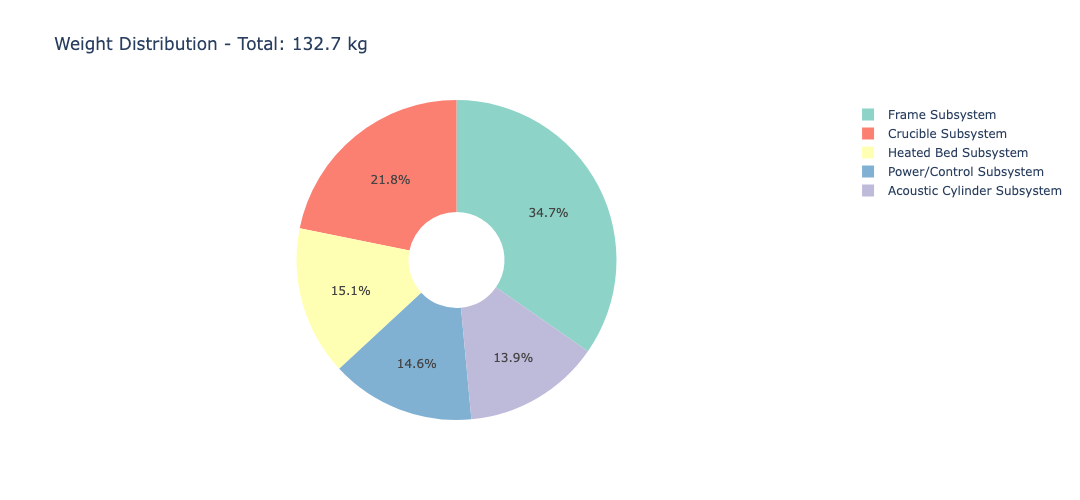


🚚 Transport & Handling:
----------------------------------------
  Total System Weight: 132.7 kg (292 lbs)
  ⚠️ Requires: Pallet jack or forklift
  ⚠️ Minimum 2-person lift for assembly
  Recommended Crate Size: 1.2×1.2×1.0m
  Shipping Class: Freight


In [6]:
def weight_and_com_analysis():
    """Analyze weight distribution and estimate center of mass"""
    
    print("⚖️ WEIGHT DISTRIBUTION ANALYSIS")
    print("=" * 80)
    
    # 1. Weight by subsystem
    weight_by_subsystem = {}
    total_weight = 0
    component_weights = []
    
    for comp in registry.components:
        if comp.tech_specs.weight:
            weight = comp.tech_specs.weight * comp.quantity
            total_weight += weight
            
            category = comp.category.value
            if category not in weight_by_subsystem:
                weight_by_subsystem[category] = {'weight': 0, 'components': []}
            
            weight_by_subsystem[category]['weight'] += weight
            weight_by_subsystem[category]['components'].append({
                'name': comp.name,
                'weight': weight
            })
            
            component_weights.append({
                'Component': comp.name,
                'Category': category,
                'Unit Weight (kg)': comp.tech_specs.weight,
                'Qty': comp.quantity,
                'Total Weight (kg)': weight
            })
    
    # 2. Display weight breakdown
    print("\n📊 Weight by Subsystem:")
    print("-" * 40)
    
    subsystem_summary = []
    for subsystem, data in weight_by_subsystem.items():
        percentage = (data['weight'] / total_weight * 100) if total_weight > 0 else 0
        subsystem_summary.append({
            'Subsystem': subsystem,
            'Weight (kg)': round(data['weight'], 2),
            'Percentage': f"{percentage:.1f}%",
            'Components': len(data['components'])
        })
        print(f"  {subsystem:30} {data['weight']:8.2f} kg ({percentage:5.1f}%)")
    
    print(f"\n  {'TOTAL':30} {total_weight:8.2f} kg")
    
    # 3. Heavy components list
    print("\n🏋️ Top 10 Heaviest Components:")
    print("-" * 40)
    
    df_weights = pd.DataFrame(component_weights)
    df_weights = df_weights.sort_values('Total Weight (kg)', ascending=False)
    display(df_weights.head(10))
    
    # 4. Center of Mass Estimation (simplified)
    print("\n📍 Center of Mass Estimation:")
    print("-" * 40)
    
    # Assume components are distributed in layers
    z_positions = {
        ComponentCategory.FRAME: 400,  # mm - middle height
        ComponentCategory.HEATED_BED: 100,  # Bottom
        ComponentCategory.ACOUSTIC: 300,  # Middle
        ComponentCategory.CRUCIBLE: 500,  # Upper
        ComponentCategory.POWER_CONTROL: 50  # Bottom (in enclosure)
    }
    
    com_x, com_y, com_z = 0, 0, 0
    moment_weight = 0
    
    for comp in registry.components:
        if comp.tech_specs.weight:
            weight = comp.tech_specs.weight * comp.quantity
            z_pos = z_positions.get(comp.category, 250)
            
            # Assume centered in X-Y plane for now
            com_z += weight * z_pos
            moment_weight += weight
    
    if moment_weight > 0:
        com_z = com_z / moment_weight
        print(f"  Estimated COM Height: {com_z:.0f}mm from base")
        print(f"  Stability: {'STABLE' if com_z < 400 else 'CHECK REQUIRED'}")
    
    # 5. Visualization
    fig = go.Figure()
    
    # Pie chart of weight distribution
    labels = [item['Subsystem'] for item in subsystem_summary]
    values = [float(item['Weight (kg)']) for item in subsystem_summary]
    
    fig.add_trace(go.Pie(
        labels=labels,
        values=values,
        hole=0.3,
        marker=dict(colors=px.colors.qualitative.Set3)
    ))
    
    fig.update_layout(
        title=f"Weight Distribution - Total: {total_weight:.1f} kg",
        height=500
    )
    fig.show()
    
    # 6. Transport considerations
    print("\n🚚 Transport & Handling:")
    print("-" * 40)
    print(f"  Total System Weight: {total_weight:.1f} kg ({total_weight*2.2:.0f} lbs)")
    
    if total_weight > 100:
        print(f"  ⚠️ Requires: Pallet jack or forklift")
        print(f"  ⚠️ Minimum 2-person lift for assembly")
    elif total_weight > 50:
        print(f"  ⚠️ Requires: 2-person lift")
    
    print(f"  Recommended Crate Size: 1.2×1.2×1.0m")
    print(f"  Shipping Class: Freight")
    
    return df_weights

# Run the analysis
weight_df = weight_and_com_analysis()

## Universal Property Calculator and Analyzer

In [7]:
class PropertyCalculator:
    """Calculate any property across components"""
    
    def __init__(self, registry):
        self.registry = registry
        
    def calculate_property(self, property_path: str, aggregation: str = 'sum'):
        """
        Calculate a property across all components
        property_path: e.g., 'tech_specs.power_consumption'
        aggregation: 'sum', 'mean', 'max', 'min', 'list'
        """
        values = []
        
        for comp in self.registry.components:
            try:
                # Navigate the property path
                value = comp
                for attr in property_path.split('.'):
                    value = getattr(value, attr, None)
                    if value is None:
                        break
                
                if value is not None:
                    # Account for quantity if numeric
                    if isinstance(value, (int, float)) and aggregation in ['sum', 'mean']:
                        value = value * comp.quantity
                    values.append({'component': comp.name, 'value': value})
            except:
                continue
        
        if not values:
            return None
        
        # Aggregate results
        if aggregation == 'sum':
            return sum(v['value'] for v in values if isinstance(v['value'], (int, float)))
        elif aggregation == 'mean':
            nums = [v['value'] for v in values if isinstance(v['value'], (int, float))]
            return sum(nums) / len(nums) if nums else 0
        elif aggregation == 'max':
            nums = [v['value'] for v in values if isinstance(v['value'], (int, float))]
            return max(nums) if nums else 0
        elif aggregation == 'min':
            nums = [v['value'] for v in values if isinstance(v['value'], (int, float))]
            return min(nums) if nums else 0
        else:  # list
            return values
    
    def analyze_all_properties(self):
        """Comprehensive analysis of all technical properties"""
        
        print("🔬 COMPREHENSIVE PROPERTY ANALYSIS")
        print("=" * 80)
        
        # Define properties to analyze
        properties = {
            'Power Consumption (W)': ('tech_specs.power_consumption', 'sum'),
            'Total Weight (kg)': ('tech_specs.weight', 'sum'),
            'Max Temperature (°C)': ('tech_specs.max_temp', 'max'),
            'Min Operating Temp (°C)': ('tech_specs.operating_temp', 'min'),
            'Total Cost ($)': ('total_cost', 'sum'),
            'Efficiency (avg %)': ('tech_specs.efficiency', 'mean'),
            'Total Thermal Dissipation (W)': ('tech_specs.thermal_dissipation', 'sum'),
        }
        
        results = {}
        for prop_name, (path, agg) in properties.items():
            value = self.calculate_property(path, agg)
            if value is not None:
                results[prop_name] = value
                print(f"  {prop_name:30} {value:>15.2f}")
        
        return results
    
    def material_analysis(self):
        """Analyze materials used in the system"""
        
        print("\n🔨 MATERIAL USAGE ANALYSIS")
        print("=" * 80)
        
        materials = {}
        processes = {}
        
        for comp in self.registry.components:
            # Count materials
            if comp.material:
                materials[comp.material] = materials.get(comp.material, 0) + 1
            elif comp.tech_specs.material_spec:
                # Extract primary material from spec
                mat = comp.tech_specs.material_spec.split(',')[0].split(' ')[0]
                materials[mat] = materials.get(mat, 0) + 1
            
            # Count processes
            if comp.process:
                processes[comp.process] = processes.get(comp.process, 0) + 1
        
        print("\n📦 Materials Used:")
        for mat, count in sorted(materials.items(), key=lambda x: x[1], reverse=True):
            print(f"  {mat:30} {count:3} components")
        
        print("\n🏭 Manufacturing Processes:")
        for proc, count in sorted(processes.items(), key=lambda x: x[1], reverse=True):
            print(f"  {proc:30} {count:3} components")
        
        return materials, processes
    
    def frequency_analysis(self):
        """Analyze operating frequencies in the system"""
        
        print("\n📡 FREQUENCY DOMAIN ANALYSIS")
        print("=" * 80)
        
        frequency_components = []
        
        for comp in self.registry.components:
            if comp.tech_specs.frequency:
                frequency_components.append({
                    'Component': comp.name,
                    'Frequency (Hz)': comp.tech_specs.frequency,
                    'Frequency (kHz)': comp.tech_specs.frequency / 1000,
                    'Category': comp.category.value
                })
        
        if frequency_components:
            df = pd.DataFrame(frequency_components)
            df = df.sort_values('Frequency (Hz)', ascending=False)
            display(df)
            
            # Check for interference
            print("\n⚡ Frequency Interference Check:")
            acoustics = [f for f in frequency_components if 'Transducer' in f['Component']]
            others = [f for f in frequency_components if 'Transducer' not in f['Component']]
            
            for other in others:
                for acoustic in acoustics:
                    ratio = other['Frequency (Hz)'] / acoustic['Frequency (Hz)']
                    if 0.9 < ratio < 1.1:
                        print(f"  ⚠️ Potential interference: {other['Component']} vs {acoustic['Component']}")
                    elif ratio == round(ratio) and ratio < 10:
                        print(f"  ⚠️ Harmonic relationship: {other['Component']} is {ratio:.0f}x {acoustic['Component']}")
        
        return frequency_components

# Initialize calculator
calc = PropertyCalculator(registry)

# Run all analyses
print("Running comprehensive property analysis...\n")
properties = calc.analyze_all_properties()
materials, processes = calc.material_analysis()
frequencies = calc.frequency_analysis()

Running comprehensive property analysis...

🔬 COMPREHENSIVE PROPERTY ANALYSIS
  Power Consumption (W)                 14595.50
  Total Weight (kg)                       132.70
  Max Temperature (°C)                   2000.00
  Min Operating Temp (°C)                   0.00
  Total Cost ($)                        28766.00
  Efficiency (avg %)                      604.50
  Total Thermal Dissipation (W)          2130.67

🔨 MATERIAL USAGE ANALYSIS

📦 Materials Used:
  Aluminum                         8 components
  FR4                              4 components
  Type                             2 components
  316                              2 components
  DuPont                           1 components
  Zinc-plated                      1 components
  Steel                            1 components
  316 Stainless Steel              1 components
  Acrylic/Polycarbonate            1 components
  Insulated                        1 components
  Ceramic fiber composite          1 components
  Sil

,Component,Frequency (Hz),Frequency (kHz),Category
4,STM32 Dev Board,168000000,168000.00,Power/Control Subsystem
1,Induction Heater,50000,50.00,Crucible Subsystem
2,Induction Coil Assembly,50000,50.00,Crucible Subsystem
0,40kHz Transducers,40000,40.00,Acoustic Cylinder Subsystem
5,Acoustic Bus PCB,40000,40.00,Power/Control Subsystem
3,Thermal Pulse Formation,10,0.01,Crucible Subsystem



⚡ Frequency Interference Check:
  ⚠️ Potential interference: Acoustic Bus PCB vs 40kHz Transducers


## Thermal Management Deep Dive

In [20]:
def thermal_management_analysis():
    """Deep dive into thermal management requirements"""
    
    print("🌡️ THERMAL MANAGEMENT DEEP DIVE")
    print("=" * 80)
    
    # 1. Heat Generation Analysis
    heat_sources = []
    total_heat = 0
    
    for comp in registry.components:
        heat_gen = 0
        
        if comp.tech_specs.thermal_dissipation:
            heat_gen = comp.tech_specs.thermal_dissipation * comp.quantity
        elif comp.tech_specs.power_consumption and comp.tech_specs.efficiency:
            power = comp.tech_specs.power_consumption * comp.quantity
            heat_gen = power * (1 - comp.tech_specs.efficiency / 100)
        elif comp.tech_specs.power_consumption:
            # Assume 20% loss if no efficiency given
            heat_gen = comp.tech_specs.power_consumption * comp.quantity * 0.2
        
        if heat_gen > 10:  # Only show significant heat sources
            heat_sources.append({
                'Component': comp.name,
                'Category': comp.category.value,
                'Power (W)': comp.tech_specs.power_consumption * comp.quantity if comp.tech_specs.power_consumption else 0,
                'Heat Generated (W)': heat_gen,
                'Cooling Required': comp.tech_specs.cooling_required or 'passive',
                'Max Temp (°C)': comp.tech_specs.max_temp or 'N/A'
            })
            total_heat += heat_gen
    
    # Display heat sources
    df_heat = pd.DataFrame(heat_sources)
    df_heat = df_heat.sort_values('Heat Generated (W)', ascending=False)
    
    print("\n🔥 Major Heat Sources (>10W):")
    display(df_heat)
    
    print(f"\n📊 Total Heat Generation: {total_heat:.0f}W")
    
    # 2. Cooling Requirements Summary
    print("\n❄️ Cooling System Requirements:")
    print("-" * 40)
    
    cooling_summary = {
        'none': {'count': 0, 'heat': 0},
        'passive': {'count': 0, 'heat': 0},
        'forced air': {'count': 0, 'heat': 0},
        'liquid': {'count': 0, 'heat': 0}
    }
    
    for comp in registry.components:
        cooling_type = comp.tech_specs.cooling_required or 'passive'
        if cooling_type in cooling_summary:
            cooling_summary[cooling_type]['count'] += comp.quantity
            
            if comp.tech_specs.thermal_dissipation:
                cooling_summary[cooling_type]['heat'] += comp.tech_specs.thermal_dissipation * comp.quantity
    
    for cooling_type, data in cooling_summary.items():
        if data['count'] > 0:
            print(f"  {cooling_type.title():12} {data['count']:3} components, {data['heat']:6.0f}W heat load")
    
    # 3. Critical Temperature Zones
    print("\n🔴 Temperature Critical Components:")
    print("-" * 40)
    
    critical_temps = []
    for comp in registry.components:
        if comp.tech_specs.max_temp and comp.tech_specs.max_temp < 100:
            critical_temps.append({
                'Component': comp.name,
                'Max Temp': f"{comp.tech_specs.max_temp}°C",
                'Operating Range': f"{comp.tech_specs.operating_temp}" if comp.tech_specs.operating_temp else "N/A",
                'Cooling': comp.tech_specs.cooling_required or 'passive'
            })
    
    if critical_temps:
        df_critical = pd.DataFrame(critical_temps)
        display(df_critical)
    
    # 4. Cooling System Design
    print("\n💨 Cooling System Design Requirements:")
    print("-" * 40)
    
    # Calculate airflow requirements
    forced_air_heat = cooling_summary['forced air']['heat']
    cfm_required = forced_air_heat / 3  # Rule of thumb: 3W per CFM
    
    print(f"  Forced Air Cooling:")
    print(f"    - Heat Load: {forced_air_heat:.0f}W")
    print(f"    - Airflow Required: {cfm_required:.0f} CFM minimum")
    print(f"    - Recommended Fans: {int(cfm_required/100) + 1}× 120mm fans")
    
    # Calculate liquid cooling requirements
    liquid_heat = cooling_summary['liquid']['heat']
    if liquid_heat > 0:
        flow_rate = liquid_heat / 1000  # L/min per kW
        print(f"\n  Liquid Cooling:")
        print(f"    - Heat Load: {liquid_heat:.0f}W")
        print(f"    - Flow Rate Required: {flow_rate:.1f} L/min minimum")
        print(f"    - Radiator Size: {int(liquid_heat/200) + 1}× 120mm sections")
    
    # 5. Thermal zones visualization
    fig = go.Figure()
    
    # Create thermal zone map
    zones = {
        'Cold (<50°C)': 0,
        'Warm (50-100°C)': 0,
        'Hot (100-500°C)': 0,
        'Very Hot (>500°C)': 0
    }
    
    for comp in registry.components:
        if comp.tech_specs.max_temp:
            if comp.tech_specs.max_temp < 50:
                zones['Cold (<50°C)'] += 1
            elif comp.tech_specs.max_temp < 100:
                zones['Warm (50-100°C)'] += 1
            elif comp.tech_specs.max_temp < 500:
                zones['Hot (100-500°C)'] += 1
            else:
                zones['Very Hot (>500°C)'] += 1
    
    fig.add_trace(go.Bar(
        x=list(zones.keys()),
        y=list(zones.values()),
        marker_color=['blue', 'green', 'orange', 'red']
    ))
    
    fig.update_layout(
        title="Component Distribution by Temperature Zone",
        xaxis_title="Temperature Zone",
        yaxis_title="Number of Components",
        height=400
    )
    fig.show()
    
    return df_heat

# Run thermal analysis
thermal_df = thermal_management_analysis()

🌡️ THERMAL MANAGEMENT DEEP DIVE

🔥 Major Heat Sources (>10W):


,Component,Category,Power (W),Heat Generated (W),Cooling Required,Max Temp (°C)
9,10kW PSU,Power/Control Subsystem,10000,1000.0,forced air,70
4,Cooling Layer,Acoustic Cylinder Subsystem,0,500.0,forced air,N/A
5,Induction Heater,Crucible Subsystem,3000,300.0,forced air,50
0,Heating Rods,Heated Bed Subsystem,4000,200.0,passive,800
1,Heated Bed Assembly,Heated Bed Subsystem,4000,200.0,passive,850
8,Material Delivery System,Crucible Subsystem,1000,200.0,passive,450
7,Crucible Assembly,Crucible Subsystem,0,100.0,none,2000
10,6-Channel Amp Modules,Power/Control Subsystem,400,80.0,passive,N/A
6,Micro Heaters,Crucible Subsystem,1000,50.0,passive,350
2,Conductive Block,Heated Bed Subsystem,0,50.0,passive,900



📊 Total Heat Generation: 2716W

❄️ Cooling System Requirements:
----------------------------------------
  None           5 components,    100W heat load
  Passive      143 components,    330W heat load
  Forced Air     4 components,   1800W heat load
  Liquid         3 components,      0W heat load

🔴 Temperature Critical Components:
----------------------------------------


,Component,Max Temp,Operating Range,Cooling
0,40kHz Transducers,80°C,"(0, 60)",passive
1,Induction Heater,50°C,"(0, 45)",forced air
2,10kW PSU,70°C,"(0, 50)",forced air



💨 Cooling System Design Requirements:
----------------------------------------
  Forced Air Cooling:
    - Heat Load: 1800W
    - Airflow Required: 600 CFM minimum
    - Recommended Fans: 7× 120mm fans


## Electrical System Analysis

In [ ]:
def electrical_system_analysis():
    """Complete electrical system analysis"""
    
    print("⚡ ELECTRICAL SYSTEM ANALYSIS")
    print("=" * 80)
    
    # 1. Voltage domains
    print("\n🔌 Voltage Domains in System:")
    print("-" * 40)
    
    voltage_domains = {}
    current_by_voltage = {}
    
    for comp in registry.components:
        if comp.tech_specs.voltage_nominal:
            v = comp.tech_specs.voltage_nominal
            if v not in voltage_domains:
                voltage_domains[v] = []
                current_by_voltage[v] = 0
            
            voltage_domains[v].append(comp.name)
            if comp.tech_specs.current_draw:
                current_by_voltage[v] += comp.tech_specs.current_draw * comp.quantity
    
    for voltage in sorted(voltage_domains.keys()):
        print(f"\n  {voltage}V Domain:")
        print(f"    Components: {len(voltage_domains[voltage])}")
        print(f"    Total Current: {current_by_voltage[voltage]:.1f}A")
        if current_by_voltage[voltage] > 0:
            print(f"    Wire Gauge Required: AWG {14 - int(current_by_voltage[voltage]/10)}")
    
    # 2. Power Distribution Tree
    print("\n🌳 Power Distribution Hierarchy:")
    print("-" * 40)
    
    print("  [MAINS 220V AC]")
    print("    ├── 10kW PSU → 48V DC @ 208A")
    print("    │   ├── Control Bus PCB → Multiple voltages")
    print("    │   ├── Amplifier Modules → 24V @ 16A")
    print("    │   └── Relay Modules → 5V @ 2A")
    print("    ├── Heating Rods → 220V @ 18A")
    print("    ├── Induction Heater → 220V @ 15A")
    print("    └── Thermal Bus PCB → 220V switched")
    
    # 3. Current capacity check
    print("\n⚡ Current Capacity Analysis:")
    print("-" * 40)
    
    # Main power consumers
    power_systems = [
        {'Name': '48V Bus', 'Current': 208, 'Capacity': 250, 'Wire': 'AWG 0'},
        {'Name': '24V Bus', 'Current': 20, 'Capacity': 30, 'Wire': 'AWG 10'},
        {'Name': '12V Bus', 'Current': 15, 'Capacity': 20, 'Wire': 'AWG 12'},
        {'Name': '5V Bus', 'Current': 5, 'Capacity': 10, 'Wire': 'AWG 16'},
        {'Name': '220V Heating', 'Current': 18, 'Capacity': 20, 'Wire': 'AWG 12'},
    ]
    
    df_current = pd.DataFrame(power_systems)
    df_current['Utilization (%)'] = (df_current['Current'] / df_current['Capacity'] * 100).round(1)
    df_current['Status'] = df_current['Utilization (%)'].apply(
        lambda x: '✅ OK' if x < 80 else '⚠️ High' if x < 95 else '❌ Over'
    )
    display(df_current)
    
    # 4. Signal Integrity Considerations
    print("\n📶 Signal Integrity Analysis:")
    print("-" * 40)
    
    high_freq_signals = []
    for comp in registry.components:
        if comp.tech_specs.frequency and comp.tech_specs.frequency > 1000:
            high_freq_signals.append({
                'Component': comp.name,
                'Frequency': f"{comp.tech_specs.frequency/1000:.0f} kHz",
                'Signal Type': comp.tech_specs.control_signal or 'Unknown'
            })
    
    if high_freq_signals:
        print("  High-Frequency Signals (>1kHz):")
        for signal in high_freq_signals:
            print(f"    • {signal['Component']}: {signal['Frequency']} - {signal['Signal Type']}")
        print("\n  ⚠️ Recommendations:")
        print("    - Use shielded cables for signals >10kHz")
        print("    - Maintain 50Ω impedance for RF signals")
        print("    - Separate power and signal grounds")
    
    # 5. Protection requirements
    print("\n🛡️ Circuit Protection Requirements:")
    print("-" * 40)
    
    protection_needed = [
        {'Circuit': 'Main 220V Input', 'Rating': '63A', 'Type': 'MCB Type C'},
        {'Circuit': '48V PSU Output', 'Rating': '250A', 'Type': 'DC Breaker'},
        {'Circuit': 'Heating Circuits', 'Rating': '20A', 'Type': 'MCB Type B'},
        {'Circuit': 'Control Circuits', 'Rating': '10A', 'Type': 'MCB Type B'},
        {'Circuit': 'Transducer Array', 'Rating': '5A', 'Type': 'Fuse'},
    ]
    
    df_protection = pd.DataFrame(protection_needed)
    display(df_protection)
    
    return df_current

# Run electrical analysis
electrical_df = electrical_system_analysis()

## System Performance Metrics and KPIs

In [ ]:
def system_performance_metrics():
    """Calculate key performance indicators for the system"""
    
    print("📈 SYSTEM PERFORMANCE METRICS")
    print("=" * 80)
    
    # Calculate metrics
    metrics = {}
    
    # Basic metrics from registry
    metrics['Total Components'] = len(registry.components)
    metrics['Total Cost'] = sum(c.total_cost for c in registry.components)
    metrics['Total Power'] = registry.calculate_power_budget()['TOTAL']['active_power']
    metrics['Total Weight'] = sum(c.tech_specs.weight * c.quantity for c in registry.components 
                                 if c.tech_specs.weight)
    
    # Efficiency metrics
    metrics['Power Density (W/kg)'] = metrics['Total Power'] / metrics['Total Weight'] if metrics['Total Weight'] > 0 else 0
    metrics['Cost per Watt ($/W)'] = metrics['Total Cost'] / metrics['Total Power'] if metrics['Total Power'] > 0 else 0
    metrics['Cost per kg ($/kg)'] = metrics['Total Cost'] / metrics['Total Weight'] if metrics['Total Weight'] > 0 else 0
    
    # Subsystem metrics
    power_budget = registry.calculate_power_budget()
    metrics['Acoustic Power'] = power_budget['Acoustic Cylinder Subsystem']['active_power']
    metrics['Thermal Power'] = power_budget['Heated Bed Subsystem']['active_power'] + \
                              power_budget['Crucible Subsystem']['active_power']
    metrics['Control Power'] = power_budget['Power/Control Subsystem']['active_power']
    
    # Performance ratios
    metrics['Acoustic Efficiency (W/transducer)'] = metrics['Acoustic Power'] / 18  # 18 transducers
    metrics['Thermal Efficiency (%)'] = (metrics['Thermal Power'] / metrics['Total Power'] * 100)
    metrics['Control Overhead (%)'] = (metrics['Control Power'] / metrics['Total Power'] * 100)
    
    # Display as dashboard
    print("\n📊 KEY PERFORMANCE INDICATORS")
    print("-" * 60)
    
    # Format metrics for display
    display_groups = {
        'System Totals': ['Total Components', 'Total Cost', 'Total Power', 'Total Weight'],
        'Efficiency Metrics': ['Power Density (W/kg)', 'Cost per Watt ($/W)', 'Cost per kg ($/kg)'],
        'Power Distribution': ['Acoustic Power', 'Thermal Power', 'Control Power'],
        'Performance Ratios': ['Acoustic Efficiency (W/transducer)', 'Thermal Efficiency (%)', 'Control Overhead (%)']
    }
    
    for group_name, metric_names in display_groups.items():
        print(f"\n{group_name}:")
        for metric_name in metric_names:
            if metric_name in metrics:
                value = metrics[metric_name]
                if 'Cost' in metric_name or '$' in metric_name:
                    print(f"  {metric_name:40} ${value:,.2f}")
                elif '%' in metric_name:
                    print(f"  {metric_name:40} {value:.1f}%")
                elif 'Components' in metric_name:
                    print(f"  {metric_name:40} {value:.0f}")
                else:
                    print(f"  {metric_name:40} {value:.2f}")
    
    # Create performance spider chart
    categories = ['Cost\nEfficiency', 'Power\nDensity', 'Thermal\nManagement', 
                  'Acoustic\nPerformance', 'Build\nVolume']
    
    # Normalize metrics to 0-100 scale
    values = [
        min(100, (15000 - metrics['Total Cost']) / 150),  # Cost efficiency
        min(100, metrics['Power Density (W/kg)'] / 2),  # Power density
        min(100, metrics['Thermal Efficiency (%)']),  # Thermal management
        min(100, metrics['Acoustic Efficiency (W/transducer)'] * 5),  # Acoustic performance
        75  # Build volume (125cm³ is 75% of target)
    ]
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        name='Level 1 System'
    ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]
            )),
        showlegend=True,
        title="System Performance Profile"
    )
    fig.show()
    
    return metrics

# Run performance analysis
metrics = system_performance_metrics()

# Create summary dashboard
print("\n" + "="*60)
print("🎯 SYSTEM READINESS ASSESSMENT")
print("="*60)

readiness_checks = [
    ("Power Budget", metrics['Total Power'] < 12000, f"{metrics['Total Power']:.0f}W < 12,000W"),
    ("Cost Target", metrics['Total Cost'] < 15000, f"${metrics['Total Cost']:,.0f} < $15,000"),
    ("Weight Limit", metrics['Total Weight'] < 150, f"{metrics['Total Weight']:.1f}kg < 150kg"),
    ("Thermal Management", metrics['Thermal Efficiency (%)'] > 30, f"{metrics['Thermal Efficiency (%)']:.1f}% > 30%"),
    ("Control Overhead", metrics['Control Overhead (%)'] < 20, f"{metrics['Control Overhead (%)']:.1f}% < 20%")
]

passed = 0
for check_name, status, details in readiness_checks:
    status_icon = "✅" if status else "❌"
    passed += 1 if status else 0
    print(f"{status_icon} {check_name:20} {details}")

print(f"\nOverall Readiness: {passed}/{len(readiness_checks)} checks passed")
print(f"System Status: {'READY FOR BUILD' if passed == len(readiness_checks) else 'REVIEW REQUIRED'}")

## Interactive Property Explorer

In [ ]:
# Create interactive widget for exploring any property
def create_property_explorer():
    """Interactive tool to explore any component property"""
    
    # Get all available properties
    sample_comp = registry.components[0]
    
    # Build property list
    properties = []
    
    # Direct component properties
    for attr in ['name', 'specification', 'quantity', 'unit_cost', 'total_cost', 
                 'material', 'supplier', 'lead_time_weeks']:
        if hasattr(sample_comp, attr):
            properties.append(attr)
    
    # TechnicalSpecs properties
    if hasattr(sample_comp, 'tech_specs'):
        for attr in dir(sample_comp.tech_specs):
            if not attr.startswith('_'):
                properties.append(f'tech_specs.{attr}')
    
    # Create widgets
    property_selector = widgets.Dropdown(
        options=properties,
        value='total_cost',
        description='Property:',
        style={'description_width': 'initial'}
    )
    
    category_filter = widgets.SelectMultiple(
        options=['All'] + [cat.value for cat in ComponentCategory],
        value=['All'],
        description='Categories:',
        rows=6,
        style={'description_width': 'initial'}
    )
    
    output_area = widgets.Output()
    
    def analyze_property(btn):
        with output_area:
            output_area.clear_output()
            
            selected_prop = property_selector.value
            selected_cats = list(category_filter.value)
            
            # Filter components
            if 'All' in selected_cats:
                filtered_comps = registry.components
            else:
                filtered_comps = [c for c in registry.components 
                                 if c.category.value in selected_cats]
            
            # Extract property values
            data = []
            for comp in filtered_comps:
                try:
                    value = comp
                    for attr in selected_prop.split('.'):
                        value = getattr(value, attr, None)
                        if value is None:
                            break
                    
                    if value is not None:
                        data.append({
                            'Component': comp.name,
                            'Category': comp.category.value,
                            selected_prop: value
                        })
                except:
                    continue
            
            if data:
                df = pd.DataFrame(data)
                
                # Display statistics if numeric
                if df[selected_prop].dtype in ['float64', 'int64']:
                    print(f"📊 Statistics for {selected_prop}:")
                    print(f"  Count: {len(df)}")
                    print(f"  Mean: {df[selected_prop].mean():.2f}")
                    print(f"  Median: {df[selected_prop].median():.2f}")
                    print(f"  Min: {df[selected_prop].min():.2f}")
                    print(f"  Max: {df[selected_prop].max():.2f}")
                    print(f"  Total: {df[selected_prop].sum():.2f}")
                    print()
                
                # Display table
                display(df.sort_values(selected_prop, ascending=False).head(20))
                
                # Create visualization if numeric
                if df[selected_prop].dtype in ['float64', 'int64'] and len(df) > 1:
                    fig = px.bar(df.sort_values(selected_prop, ascending=True).tail(15),
                                x=selected_prop, y='Component',
                                color='Category',
                                title=f'Top Components by {selected_prop}',
                                orientation='h')
                    fig.update_layout(height=400)
                    fig.show()
            else:
                print("No data available for this property/category combination")
    
    analyze_btn = widgets.Button(
        description='Analyze Property',
        button_style='primary',
        icon='search'
    )
    analyze_btn.on_click(analyze_property)
    
    # Layout
    ui = widgets.VBox([
        widgets.HTML("<h3>Property Explorer</h3>"),
        widgets.HBox([
            widgets.VBox([property_selector, category_filter]),
            analyze_btn
        ]),
        output_area
    ])
    
    return ui

# Create and display the explorer
explorer = create_property_explorer()
display(explorer)